In [1]:
from gurobipy import *

## 本研究

In [165]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
class CVaR:
    def __init__(self,ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC):
        self.ship_num=ship_num
        self.stack_num=stack_num
        self.height=height
        self.n_init=n_init
        self.beta=beta
        self.size=size
        self.size_=size_
        self.mean=mean
        self.cov=cov
        self.OC=OC
        self.O1=[i+1 for i in range(ship_num)]
        self.S=[i+1 for i in range(stack_num)]
        self.H=[i+1 for i in range(height)]
        self.P=[i+1 for i in range(ship_num)]
        self.f=stack_num*height-sum(n_init)

        # 期待値と分散共分散行列の準備
        data_1 = np.random.multivariate_normal(mean, cov, size=self.size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        self.O=O_.tolist()

    def solve(self):
        self.model=Model("CVaR")
        alpha=self.model.addVar(vtype="C",name="alpha")
        u=self.model.addVar(vtype="C",name="u")


        # 変数の定義
        x,c,d={},{},{}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s,h,p]=self.model.addVar(vtype="B",name="x_"+str(s)+str(h)+str(p))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for i,o in enumerate(self.O):
                    c[s,h,i]=self.model.addVar(vtype="c",lb=0,name="c_"+str(s)+str(h)+str(i))

        for i in range(len(self.O)):
            d[i]=self.model.addVar(vtype="C",lb=0)

        self.model.update()
        self.model._vars=self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s,h,p] for s in self.S for h in self.H)==self.n_init[p-1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s,h,p] for p in self.P)<=1)

        for s in self.S:
            for h in range(1,len(self.H)):
                self.model.addConstr(quicksum(x[s,h+1,p] for p in self.P)<=quicksum(x[s,h,p] for p in self.P))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for h_ in range(1,h):
                    for i,o in enumerate(self.OC):
                        for j,p in enumerate(o):
                            self.model.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

        for i in range(len(self.OC)):
            self.model.addConstr(d[i]>=quicksum(c[s,h,i] for s in self.S for h in self.H if h!=1)-alpha)

        self.model.addConstr(u>=alpha+quicksum(d[i] for i in range(len(self.O)))/((1-self.beta)*len(self.O)))
        self.model.setObjective(u)
        if self.f>=self.height:
            self.model.optimize()
        else:
            print("実行不可")

    def get_optimal_sol(self):
        if self.model.Status==GRB.OPTIMAL:
            x_opt={}
            c_opt={}
            for var in self.model.getVars():
                if "x_" in var.VarName:
                    print(var)
                    s=int(var.VarName.split("_")[-1][-3])
                    h=int(var.VarName.split("_")[-1][-2])
                    p=int(var.VarName.split("_")[-1][-1])
                    x_opt[s,h,p]=var.X
                if "c_" in var.VarName:
                    s=int(var.VarName.split("_")[-1][-3])
                    h=int(var.VarName.split("_")[-1][-2])
                    i=int(var.VarName.split("_")[-1][-1])
                    c_opt[s,h,i]=var.X
                if "alpha" in var.VarName:
                    alpha_opt=var.X
                if "u" in var.VarName:
                    u_opt=var.X
            return (x_opt,c_opt,alpha_opt,u_opt)
        else:
            return None

    def get_optimal_val(self):
        if self.model.Status==GRB.OPTIMAL:
            self.LB=self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    def get_penalty(self):
        if self.model.Status==GRB.OPTIMAL:
            EPS=1.e-6
            self.result=np.zeros((self.height,self.stack_num))
            x_opt,c_opt,alpha_opt,u_opt=self.get_optimal_sol()
            for (s,h,p) in x_opt:
                if x_opt[s,h,p].X>EPS:
                    self.result[self.height-h][s-1]=int(p)
                self.result=self.result.astype(int)
                self.penalty=[]
                for k in self.O:
                    OO=k
                    a=0
                    for j in range(self.stack_num):
                        for i in range(1,self.height):
                            for i_ in range(i+1,self.height+1):
                                if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
                                    if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
                                        # print(j+1,height-i+1,O)
                                        a+=1
                                        # print("penalty!")
                                            # print(i,i_,j+1,O)
                                        break
                    self.penalty.append(a)
                self.zk=[i for i, x in enumerate(self.penalty) if x-alpha_opt>0]

In [166]:
inst=[3,3,[1,2,3]]
model=CVaR(len(inst[2]),inst[0],inst[1],inst[2],100,100,0.75,mean,cov,[])

In [167]:
model.solve()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19 rows, 729 columns and 192 nonzeros
Model fingerprint: 0x338c3867
Variable types: 702 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [112]:
stack=3
ship_num=3
height=3
m = CVaR(3,3,3,[2,1,1],100,1000,0.75,mean,cov,OC=[])
# コールバックで制約を追加するには LazyConstraints オプションを設定する必要がある
# m.setParam('LazyConstraints', 1)
# コールバックを指定して最適化
m.optimize(callback=callback)

NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Optimize a model with 19 rows, 729 columns and 192 nonzeros


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Model fingerprint: 0x47b20413


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Variable types: 702 continuous, 27 integer (27 binary)


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Coefficient statistics:


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


  Matrix range     [4e-02, 1e+00]


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


  Objective range  [1e+00, 1e+00]


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


  Bounds range     [1e+00, 1e+00]


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


  RHS range        [1e+00, 2e+00]


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Found heuristic solution: objective 0.0000000


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Explored 0 nodes (0 simplex iterations) in 1.38 seconds (0.00 work units)


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Thread count was 1 (of 8 available processors)


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Solution count 1: 0 


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Optimal solution found (tolerance 1.00e-04)


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


NameError: name 'S' is not defined

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in callback
  File "src\gurobipy\gurobi.pxi", line 3631, in gurobipy.quicksum
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_6596\2398368340.py", line 9, in <genexpr>
NameError: name 'S' is not defined


User-callback calls 24, time in user-callback 2.64 sec


In [110]:
def callback(m, where):

    for var in m._vars:
        if "u" in var.VarName:
            u_var=var
        if "alpha" in var.VarName:
            alpha_var=var
    m.cbLazy(u_var>=alpha_var+quicksum(quicksum(m._c[s,h,i] for s in S for h in H if h!=1)-alpha_var for i in zk))

In [ ]:
def culc()
  print("================================================")

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:


    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    global LB
    LB=m.objVal
    # print(result)

    global penalty
    penalty=[]
    for k in O:
      OO=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if OO.index(result[i-1][j])>OO.index(result[i_-1][j]):
                          # print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      global zk
      zk=[i for i, x in enumerate(penalty) if x-alpha.X>0]
      # print(a)
    # penalty=np.sort(penalty)
    # print(penalty)

    # penalty=penalty[round(0.75*size):]
    # print(penalty)

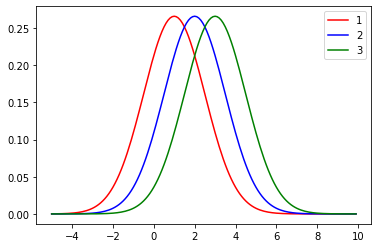

In [48]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline

color=["r","b","g","y","purple","black"]
mean=[1,2,3]
X=np.arange(-5,10,0.1)
covl=[1.5 for i in range(8)]
for i,j in enumerate(mean):
  Y=norm.pdf(X,j,covl[i])
  plt.plot(X,Y,color=color[i%6],label=i+1)
# plt.title("scale="+str(y[0]))
plt.legend()
plt.show()

In [86]:
size=3000
size_=10000
beta=0.75
inst=[3,4,[1,1,1,1,1,1,1,1]]
pcvar=[]
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=mean
covl=covl
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[1]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0
OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
while UB-LB>=EPS:
    print("UB=",UB)
    print("LB=",LB)
    print("UB-LB=",UB-LB)
    print("LEN=",len(OC))
    CVaR(len(inst[2]),inst[0],inst[1],inst[2],size,size_,beta,mean,cov,OC)
    n=0
    while n<beta*size:
        n+=1
    tau=n
    N_sigma=np.sort(penalty)
    alpha_=N_sigma[tau-1]

    UB=((tau/size-beta)*alpha_+sum(N_sigma[tau:]))/((1-beta)*size)
    UB_k.append(UB)
    UB=min(UB_k)
    for b in zk:
        if not O[b] in OC:
            OC.append(O[b])
    a+=1
    # print(OC)
print("finish!!")


UB= 1000
LB= 0
UB-LB= 1000
LEN= 0
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 29 rows, 30097 columns and 336 nonzeros
Model fingerprint: 0x9ff11e15
Variable types: 30001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
VaR= 0.0
the objective function 0.0
UB= 5.0
LB= 0.0
UB-LB= 5.0
LEN= 235
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 32 rows, 48 columns and 159 nonzeros
Model fingerprint: 0xdf3425ed
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 32 rows, 45 columns, 150 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Found heuristic solution: objective 1.0000000

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

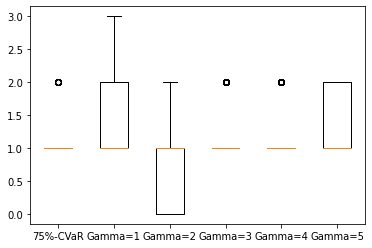

In [87]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,len(inst[2]))).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
penalty_cvar=penalty_cvar[round(0.75*size_):]
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
#   print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
# plt.hist(penalty_cvar,bins=50)
# plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 32 rows, 48 columns and 159 nonzeros
Model fingerprint: 0xdf3425ed
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 32 rows, 45 columns, 150 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Found heuristic solution: objective 1.0000000

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

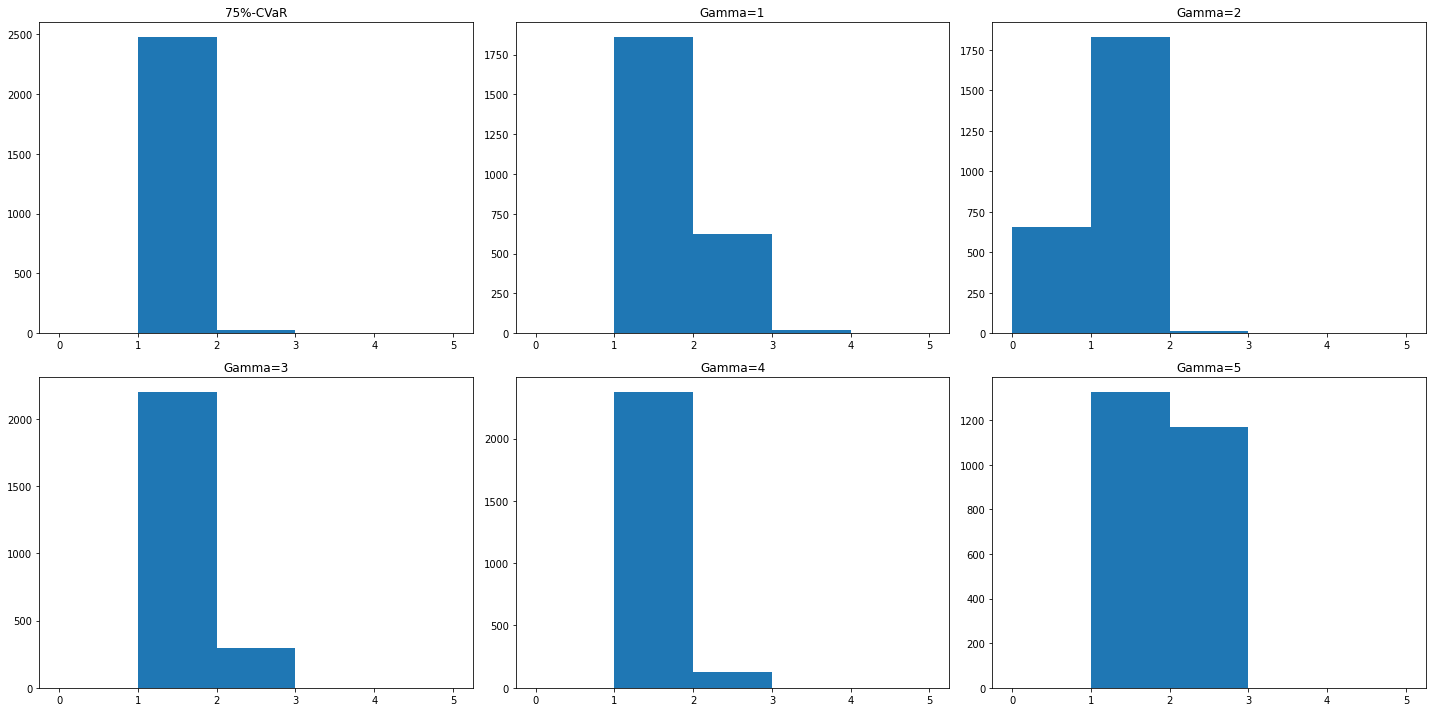

len= 2500


In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
  # print(prob)
  # data+=(tuple(prob),)
  # l.append("Gamma="+str(g))
  # print("data=",data)
# plt.boxplot(data,labels=l)
# plt.show()

  ax[int(g/3)][g%3].hist(prob,bins=5,range=(0,5))
  ax[int(g/3)][g%3].set_title("Gamma="+str(g))
ax[0][0].hist(penalty_cvar,bins=5,range=(0,5))
ax[0][0].set_title("75%-CVaR")
plt.show()
print("len=",len(prob))

In [89]:
print(result)

[[0 0 0]
 [0 4 1]
 [2 5 3]
 [6 8 7]]
